In [736]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'figure.figsize': (10, 3),
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'serif'],
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'axes.grid': True,
    'lines.linewidth': 2,
    'lines.markersize': 7,
    'axes.facecolor': '#f5f5f5',
    'figure.facecolor': '#f5f5f5',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.loc': 'best',
})


In [25]:
def simulate_vasicek_short_rates_euler(r0, kappa, theta, sigma, t, dt, seed=None):
    """
    Simulates the Vasicek short rates model using the 
    Euler-Maruyama discretization. 
    
    Parameters:
    r0 (float): Initial (current) short rate.
    kappa (float): Speed of mean reversion.
    theta (float): Long-term mean level of the short rate.
    sigma (float): Annualized volatility of the short rate process.
    t (float): Number of years to simulate.
    dt (float): Time step size.
    
    Returns:
    times (np.ndarray): Time steps.
    rates (np.ndarray): Simulated short rates.
    """

    np.random.seed(seed)
    
    nd = int(t / dt)

    times = np.linspace(0, t, nd)

    rates = np.zeros(nd)
    rates[0] = r0

    diffusion = sigma * np.random.normal(0, np.sqrt(dt), nd)

    for t in range(1, nd):
        dr = kappa * (theta - rates[t-1]) * dt + diffusion[t]
        rates[t] = rates[t-1] + dr
        
    return times, rates


In [26]:
def simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, t, dt, seed=None):
    """
    Simulates the Vasicek short rates model using the 
    Doob (analytical solution)
    
    Parameters:
    r0 (float): Initial (current) short rate.
    kappa (float): Speed of mean reversion.
    theta (float): Long-term mean level of the short rate.
    sigma (float): Annualized volatility of the short rate process.
    t (float): Number of years to simulate.
    dt (float): Time step size.
    
    Returns:
    times (np.ndarray): Time steps.
    rates (np.ndarray): Simulated short rates.
    """

    np.random.seed(seed)

    nd = int(t / dt)

    times = np.linspace(0, t, nd)

    rates = np.zeros(nd)
    rates[0] = r0

    exp_kappa_dt = np.exp(-kappa * dt)
    variance = sigma**2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
    for t in range(1, nd):
        exp_rate = (theta * (1 - exp_kappa_dt) + rates[t-1] * exp_kappa_dt)
        rates[t] = np.random.normal(exp_rate, np.sqrt(variance))
    
    return times, rates


In [155]:
def vasicek_log_likelihood(params, rates, dt):
    kappa, theta, sigma = params
    
    exp_r = rates[:-1] + kappa * (theta - rates[:-1]) * dt
    var_r = sigma**2 * dt
    
    logL = np.sum(
        -0.5 * (
            np.log(2 * np.pi * var_r) + 
            (rates[1:] - exp_r)**2 / var_r
        )
    )
    
    return -logL

def calibrate_vasicek_mle(rates, dt):
    initial_params = [0.05, np.mean(rates), np.std(np.diff(rates)) * np.sqrt(1/dt)]
    bounds = [(0, None), (None, None), (1e-8, None)]
    
    result = minimize(
        vasicek_log_likelihood, initial_params, 
        args=(rates, dt), bounds=bounds, method='POWELL'
    )
    
    kappa, theta, sigma = result.x
    return kappa, theta, sigma


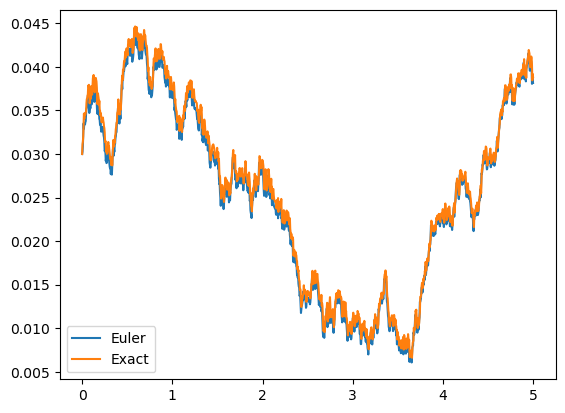

In [695]:
# Vasicek simulation parameters
halflife = 3
r0 = 0.03
kappa = 1 - 0.5 ** (1/halflife) # halflife = 2Y
theta = 0.05
sigma = 0.01
t = 5.0  # Total time in years
dt = 1/252  # Daily time steps
seed = 0

# Simulate using Euler discretization
rates_euler = simulate_vasicek_short_rates_euler(r0, kappa, theta, sigma, t, dt, seed)
plt.plot(*rates_euler, label='Euler')

# Simulate using exact discretization
rates_exact = simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, t, dt, seed)
plt.plot(*rates_exact, label='Exact')

plt.legend()
plt.show()

rates = rates_exact[1]  # Assuming market observed short rates are the simulated exact rates


In [696]:
# MLE Parameter Estimation
kappa_mle, theta_mle, sigma_mle = calibrate_vasicek_mle(rates, dt)
print(f'MLE calibrated parameters: kappa={kappa_mle}, theta={theta_mle}, sigma={sigma_mle}')
print(f"Ground truth: kappa={kappa}, theta={theta}, sigma={sigma}")

MLE calibrated parameters: kappa=0.2862184746173285, theta=0.0320823949707456, sigma=0.00977219438409873
Ground truth: kappa=0.2062994740159002, theta=0.05, sigma=0.01


In [697]:
class ParticleFilterOU:
    def __init__(self, num_particles=1000, dt=1/252, resample_threshold=0.5, jitter_scale=0.01):
        self.num_particles = num_particles
        self.dt = dt
        self.resample_threshold = resample_threshold
        self.jitter_scale = jitter_scale
        self.kappa_particles = None
        self.theta_particles = None
        self.sigma_particles = None
        self.weights = None

    def initialize_particles(self, kappa_range, theta_range, sigma_range):
        """Initialize particles uniformly within given ranges."""
        self.kappa_particles = np.random.uniform(kappa_range[0], kappa_range[1], self.num_particles)
        self.theta_particles = np.random.uniform(theta_range[0], theta_range[1], self.num_particles)
        self.sigma_particles = np.random.uniform(sigma_range[0], sigma_range[1], self.num_particles)
        self.weights = np.ones(self.num_particles) / self.num_particles

    def predict(self):
        """Predict the next state of the particles (No state evolution in parameters)."""
        pass  # In this case, the parameters do not evolve over time.

    def update(self, r_prev, r_curr):
        """Update particle weights based on the observed data."""
        drift = self.kappa_particles * (self.theta_particles - r_prev) * self.dt
        variance = self.sigma_particles**2 * self.dt
        likelihoods = np.exp(-0.5 * ((r_curr - r_prev - drift)**2) / variance) / np.sqrt(2 * np.pi * variance)
        self.weights *= likelihoods
        self.weights /= np.sum(self.weights)

    def resample_and_perturb(self):
        """Resample particles based on their weights and add perturbation (jitter)."""
        effective_sample_size = 1.0 / np.sum(self.weights**2)
        if effective_sample_size / self.num_particles < self.resample_threshold:
            indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=self.weights)
            self.kappa_particles = self.kappa_particles[indices]
            self.theta_particles = self.theta_particles[indices]
            self.sigma_particles = self.sigma_particles[indices]

            # Perturb particles with Gaussian noise
            self.kappa_particles += np.random.normal(0, self.jitter_scale * np.std(self.kappa_particles), self.num_particles)
            self.theta_particles += np.random.normal(0, self.jitter_scale * np.std(self.theta_particles), self.num_particles)
            self.sigma_particles += np.random.normal(0, self.jitter_scale * np.std(self.sigma_particles), self.num_particles)

            # Re-normalize weights
            self.weights.fill(1.0 / self.num_particles)

    def weighted_median(self, data, weights):
        """Compute the weighted median of the data."""
        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_weights = weights[sorted_indices]
        cumulative_weights = np.cumsum(sorted_weights)

        cutoff = cumulative_weights[-1] / 2.0
        median_index = np.where(cumulative_weights >= cutoff)[0][0]
        return sorted_data[median_index]

    def estimate_parameters_weighted_median(self):
        """Estimate the parameters by computing the weighted median of the particles."""
        kappa_est = self.weighted_median(self.kappa_particles, self.weights)
        theta_est = self.weighted_median(self.theta_particles, self.weights)
        sigma_est = self.weighted_median(self.sigma_particles, self.weights)
        return kappa_est, theta_est, sigma_est


    def estimate_parameters_weighted_mean(self):
        """Estimate the parameters by computing the weighted mean of the particles."""
        kappa_est = np.sum(self.kappa_particles * self.weights)
        theta_est = np.sum(self.theta_particles * self.weights)
        sigma_est = np.sum(self.sigma_particles * self.weights)
        return kappa_est, theta_est, sigma_est

    def run_particle_filter(self, data, kappa_range, theta_range, sigma_range):
        """Run the particle filter on the given data."""
        self.initialize_particles(kappa_range, theta_range, sigma_range)
        
        for t in range(1, len(data)):
            self.predict()
            self.update(data[t-1], data[t])
            self.resample_and_perturb()

        return self.estimate_parameters_weighted_mean()



In [698]:
pf = ParticleFilterOU(num_particles=250000, dt=dt, jitter_scale=1/np.sqrt(250000))
kappa_range = (0.00, 5.00)
theta_range = (0.00, 0.10)
sigma_range = (1e-8, 0.05)
kappa_est, theta_est, sigma_est = pf.run_particle_filter(rates, kappa_range, theta_range, sigma_range)

print(f"True kappa: {kappa}, PF Estimated kappa: {kappa_est}, MLE Estimated kappa: {kappa_mle}")
print(f"True theta: {theta}, PF Estimated theta: {theta_est}, MLE Estimated theta: {theta_mle}")
print(f"True sigma: {sigma}, PF Estimated sigma: {sigma_est}, MLE Estimated sigma: {sigma_mle}")

#sns.scatterplot(x=pf.theta_particles, y=pf.kappa_particles, hue=pf.weights, palette="viridis")

True kappa: 0.2062994740159002, PF Estimated kappa: 0.3146047105840802, MLE Estimated kappa: 0.2862184746173285
True theta: 0.05, PF Estimated theta: 0.039118976836957364, MLE Estimated theta: 0.0320823949707456
True sigma: 0.01, PF Estimated sigma: 0.009734898631476028, MLE Estimated sigma: 0.00977219438409873


In [ ]:
kappa_ests = []
theta_ests = []
sigma_ests = []
for _ in range(100):
    pf = ParticleFilterOU(num_particles=20000, dt=dt, jitter_scale=1)
    kappa_est, theta_est, sigma_est = pf.run_particle_filter(rates, kappa_range, theta_range, sigma_range)
    kappa_ests.append(kappa_est)
    theta_ests.append(theta_est)
    sigma_ests.append(sigma_est)

aaa = np.array(kappa_ests)
theta_ests = np.array(theta_ests)
sigma_ests = np.array(sigma_ests)

kappa_ests_mean = np.mean(kappa_ests, axis=0)
theta_ests_mean = np.mean(theta_ests, axis=0)
sigma_ests_mean = np.mean(sigma_ests, axis=0)

kappa_ests_std = np.std(kappa_ests, axis=0)
theta_ests_std = np.std(theta_ests, axis=0)
sigma_ests_std = np.std(sigma_ests, axis=0)


In [724]:
class ParticleFilterOU:
    def __init__(self, num_particles=1000, dt=1/252, resample_threshold=0.5, ess_threshold=0.5, initial_jitter_scale=0.01):
        self.num_particles = num_particles
        self.dt = dt
        self.resample_threshold = resample_threshold
        self.ess_threshold = ess_threshold  # The ESS threshold to adjust the jitter scale
        self.jitter_scale = initial_jitter_scale
        self.kappa_particles = None
        self.theta_particles = None
        self.sigma_particles = None
        self.weights = None

    def initialize_particles(self, kappa_range, theta_range, sigma_range, initial_jitter_scale=0.01):
        """Initialize particles uniformly within given ranges."""
        self.kappa_particles = np.random.uniform(kappa_range[0], kappa_range[1], self.num_particles)
        self.theta_particles = np.random.uniform(theta_range[0], theta_range[1], self.num_particles)
        self.sigma_particles = np.random.uniform(sigma_range[0], sigma_range[1], self.num_particles)
        self.weights = np.ones(self.num_particles) / self.num_particles
        self.jitter_scale = initial_jitter_scale

    def predict(self):
        """Predict the next state of the particles (No state evolution in parameters)."""
        pass  # In this case, the parameters do not evolve over time.

    def update(self, r_prev, r_curr):
        """Update particle weights based on the observed data."""
        drift = self.kappa_particles * (self.theta_particles - r_prev) * self.dt
        variance = self.sigma_particles**2 * self.dt
        likelihoods = np.exp(-0.5 * ((r_curr - r_prev - drift)**2) / variance) / np.sqrt(2 * np.pi * variance)
        self.weights *= likelihoods
        self.weights /= np.sum(self.weights)

    def resample_and_perturb(self):
        """Resample particles based on their weights and adapt perturbation based on ESS."""
        effective_sample_size = 1.0 / np.sum(self.weights**2)
        if effective_sample_size / self.num_particles < self.resample_threshold:
            indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=self.weights)
            self.kappa_particles = self.kappa_particles[indices]
            self.theta_particles = self.theta_particles[indices]
            self.sigma_particles = self.sigma_particles[indices]

            # Adapt the jitter scale based on ESS
            self.adapt_jitter_scale(effective_sample_size)
            #print(self.jitter_scale)
            # Perturb particles with Gaussian noise using the adapted jitter scale
            self.kappa_particles += np.random.normal(0, self.jitter_scale, self.num_particles)
            self.theta_particles += np.random.normal(0, self.jitter_scale * np.std(self.theta_particles), self.num_particles)
            self.sigma_particles += np.random.normal(0, self.jitter_scale * np.std(self.sigma_particles), self.num_particles)

            # Re-normalize weights
            self.weights.fill(1.0 / self.num_particles)

    def adapt_jitter_scale(self, effective_sample_size):
        """Adapt jitter scale based on the Effective Sample Size (ESS)."""
        # If ESS is too low, increase jitter scale to introduce more diversity
        if effective_sample_size / self.num_particles < self.ess_threshold:
            self.jitter_scale *= 1.1  # Increase jitter scale by 10%
        else:
            self.jitter_scale *= 0.9  # Decrease jitter scale by 10%

        # Clamp jitter scale to a reasonable range to avoid extremes
        self.jitter_scale = max(self.jitter_scale, 1e-8)  # Avoid going too low
        self.jitter_scale = min(self.jitter_scale, 1.0)   # Avoid going too high


    def weighted_median(self, data, weights):
        """Compute the weighted median of the data."""
        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_weights = weights[sorted_indices]
        cumulative_weights = np.cumsum(sorted_weights)

        cutoff = cumulative_weights[-1] / 2.0
        median_index = np.where(cumulative_weights >= cutoff)[0][0]
        return sorted_data[median_index]

    def estimate_parameters_weighted_median(self):
        """Estimate the parameters by computing the weighted median of the particles."""
        kappa_est = self.weighted_median(self.kappa_particles, self.weights)
        theta_est = self.weighted_median(self.theta_particles, self.weights)
        sigma_est = self.weighted_median(self.sigma_particles, self.weights)
        return kappa_est, theta_est, sigma_est


    def estimate_parameters_weighted_mean(self):
        """Estimate the parameters by computing the weighted mean of the particles."""
        kappa_est = np.sum(self.kappa_particles * self.weights)
        theta_est = np.sum(self.theta_particles * self.weights)
        sigma_est = np.sum(self.sigma_particles * self.weights)
        return kappa_est, theta_est, sigma_est

    def run_particle_filter(self, data, kappa_range, theta_range, sigma_range):
        """Run the particle filter on the given data."""
        self.initialize_particles(kappa_range, theta_range, sigma_range)
        
        for t in range(1, len(data)):
            self.predict()
            self.update(data[t-1], data[t])
            self.resample_and_perturb()

        return self.estimate_parameters_weighted_mean()



In [725]:
pf = ParticleFilterOU(num_particles=250000, dt=dt)
kappa_range = (0.00, 1.00)
theta_range = (0.00, 0.10)
sigma_range = (1e-8, 0.05)
kappa_est, theta_est, sigma_est = pf.run_particle_filter(rates, kappa_range, theta_range, sigma_range)

print(f"True kappa: {kappa}, PF Estimated kappa: {kappa_est}, MLE Estimated kappa: {kappa_mle}")
print(f"True theta: {theta}, PF Estimated theta: {theta_est}, MLE Estimated theta: {theta_mle}")
print(f"True sigma: {sigma}, PF Estimated sigma: {sigma_est}, MLE Estimated sigma: {sigma_mle}")

#sns.scatterplot(x=pf.theta_particles, y=pf.kappa_particles, hue=pf.weights, palette="viridis")

True kappa: 0.2062994740159002, PF Estimated kappa: 0.3713312121807215, MLE Estimated kappa: 0.2862184746173285
True theta: 0.05, PF Estimated theta: 0.0386962225070816, MLE Estimated theta: 0.0320823949707456
True sigma: 0.01, PF Estimated sigma: 0.009611351018678823, MLE Estimated sigma: 0.00977219438409873


In [726]:
kappa_ests = []
theta_ests = []
sigma_ests = []

kappa_range = (0.00, 1.00)
theta_range = (0.00, 0.10)
sigma_range = (1e-8, 0.05)

num_run = 500
np.random.seed(42)
random_seeds = np.random.randint(0, 10000, num_run)
for i in range(num_run):
    if i % 50 == 0:
        print(i)
    pf = ParticleFilterOU(num_particles=250000, dt=dt)
    _, rates =  simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, t, dt, random_seeds[i])
    kappa_est, theta_est, sigma_est = pf.run_particle_filter(rates, kappa_range, theta_range, sigma_range)
    kappa_ests.append(kappa_est)
    theta_ests.append(theta_est)
    sigma_ests.append(sigma_est)


0
50
100
150
200
250
300
350
400
450


In [727]:

#kappa_ests = np.array(kappa_ests)
#theta_ests = np.array(theta_ests)
#sigma_ests = np.array(sigma_ests)

kappa_ests_mean = np.mean(kappa_ests, axis=0)
theta_ests_mean = np.mean(theta_ests, axis=0)
sigma_ests_mean = np.mean(sigma_ests, axis=0)

kappa_ests_std = np.std(kappa_ests, axis=0)
theta_ests_std = np.std(theta_ests, axis=0)
sigma_ests_std = np.std(sigma_ests, axis=0)


In [717]:
kappa_ests_mle = []
theta_ests_mle = []
sigma_ests_mle = []

num_run = 500
np.random.seed(42)
random_seeds = np.random.randint(0, 10000, num_run)
for i in range(num_run):
    if i % 50 == 0:
        print(i)
    _, rates =  simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, t, dt, random_seeds[i])
    kappa_est, theta_est, sigma_est = calibrate_vasicek_mle(rates, dt)
    kappa_ests_mle.append(kappa_est)
    theta_ests_mle.append(theta_est)
    sigma_ests_mle.append(sigma_est)

kappa_ests_mle = np.array(kappa_ests_mle)
theta_ests_mle = np.array(theta_ests_mle)
sigma_ests_mle = np.array(sigma_ests_mle)

kappa_ests_mle_mean = np.mean(kappa_ests_mle, axis=0)
theta_ests_mle_mean = np.mean(theta_ests_mle, axis=0)
sigma_ests_mle_mean = np.mean(sigma_ests_mle, axis=0)

kappa_ests_mle_std = np.std(kappa_ests_mle, axis=0)
theta_ests_mle_std = np.std(theta_ests_mle, axis=0)
sigma_ests_mle_std = np.std(sigma_ests_mle, axis=0)

0
50
100
150
200
250
300
350
400
450


In [729]:

print(f"True kappa: {kappa}, PF Estimated kappa mean: {kappa_ests_mean}, RF Estimated kappa std: {kappa_ests_std}, MLE Estimated kappa: {kappa_ests_mle_mean}")
print(f"True theta: {theta}, PF Estimated theta mean: {theta_ests_mean}, RF Estimated theta std: {theta_ests_std}, MLE Estimated theta: {theta_ests_mle_mean}")
print(f"True sigma: {sigma}, PF Estimated sigma mean: {sigma_ests_mean}, RF Estimated sigma std: {sigma_ests_std}, MLE Estimated sigma: {sigma_ests_mle_mean}")

True kappa: 0.2062994740159002, PF Estimated kappa mean: 0.4201853423393957, RF Estimated kappa std: 0.08984630750959911, MLE Estimated kappa: 1.1744308821971503
True theta: 0.05, PF Estimated theta mean: 0.04569677088033121, RF Estimated theta std: 0.01253618638936063, MLE Estimated theta: 1.078916208056762
True sigma: 0.01, PF Estimated sigma mean: 0.010010680128602846, RF Estimated sigma std: 0.00020210192004677967, MLE Estimated sigma: 0.009992843466871801


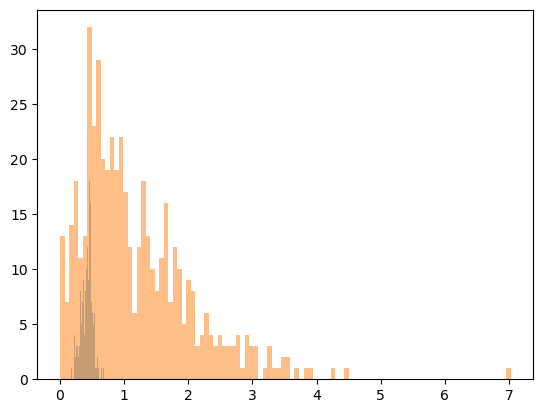

In [730]:
plt.hist(kappa_ests, bins=100, alpha=0.5);
plt.hist(kappa_ests_mle, bins=100, alpha=0.5);


In [733]:
pd.Series(kappa_ests).describe()

count    500.000000
mean       0.420185
std        0.089936
min        0.172759
25%        0.358482
50%        0.430122
75%        0.479960
max        0.680176
dtype: float64

In [735]:
import scipy
scipy.stats.mode(kappa_ests)[0], scipy.stats.mode(kappa_ests_mle)[0]



(0.29474739218362644, 0.23169876745344667)

In [587]:
kappa_ests = []
theta_ests = []
sigma_ests = []
for _ in range(100):
    pf = ParticleFilterOU(num_particles=20000, dt=dt, jitter_scale=0.19, tolerance=0.1)
    kappa_est, theta_est, sigma_est = pf.run_particle_filter(rates, kappa_range, theta_range, sigma_range)
    kappa_ests.append(kappa_est)
    theta_ests.append(theta_est)
    sigma_ests.append(sigma_est)

aaa = np.array(kappa_ests)
theta_ests = np.array(theta_ests)
sigma_ests = np.array(sigma_ests)

kappa_ests_mean = np.mean(kappa_ests, axis=0)
theta_ests_mean = np.mean(theta_ests, axis=0)
sigma_ests_mean = np.mean(sigma_ests, axis=0)

kappa_ests_std = np.std(kappa_ests, axis=0)
theta_ests_std = np.std(theta_ests, axis=0)
sigma_ests_std = np.std(sigma_ests, axis=0)


In [588]:

print(f"True kappa: {kappa}, PF Estimated kappa mean: {kappa_ests_mean}, RF Estimated kappa std: {kappa_ests_std}, MLE Estimated kappa: {kappa_mle}")
print(f"True theta: {theta}, PF Estimated theta mean: {theta_ests_mean}, RF Estimated theta std: {theta_ests_std}, MLE Estimated theta: {theta_mle}")
print(f"True sigma: {sigma}, PF Estimated sigma mean: {sigma_ests_mean}, RF Estimated sigma std: {sigma_ests_std}, MLE Estimated sigma: {sigma_mle}")

True kappa: 0.2062994740159002, PF Estimated kappa mean: 0.356313245399516, RF Estimated kappa std: 0.09695929248334405, MLE Estimated kappa: 0.2862184746173285
True theta: 0.05, PF Estimated theta mean: 0.04851170993509422, RF Estimated theta std: 0.0027338558871225784, MLE Estimated theta: 0.0320823949707456
True sigma: 0.01, PF Estimated sigma mean: 0.009734916003301423, RF Estimated sigma std: 1.52706386354035e-05, MLE Estimated sigma: 0.00977219438409873


True kappa: 0.2062994740159002, PF Estimated kappa: 0.169476142506839, MLE Estimated kappa: 0.2862184746173285
True theta: 0.05, PF Estimated theta: 0.03815907662962943, MLE Estimated theta: 0.0320823949707456
True sigma: 0.01, PF Estimated sigma: 0.009879231147870227, MLE Estimated sigma: 0.00977219438409873
0.02661436380604738, 0.009897238447656357


<Axes: >

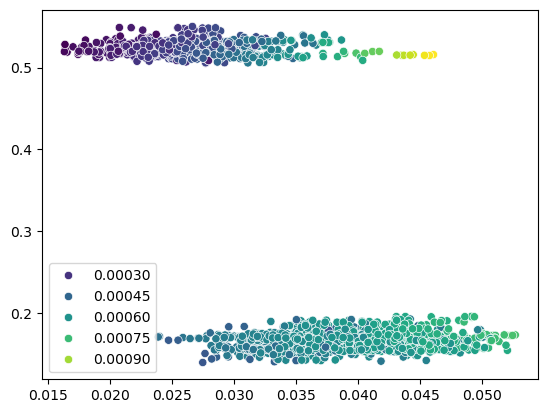

In [617]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

class ParticleFilterOU:
    def __init__(self, num_particles=1000, dt=1/252, resample_threshold=0.5, jitter_scale=0.01, tolerance=0.01):
        self.num_particles = num_particles
        self.dt = dt
        self.resample_threshold = resample_threshold
        self.jitter_scale = jitter_scale
        self.tolerance = tolerance
        self.kappa_particles = None
        self.theta_particles = None
        self.sigma_particles = None
        self.weights = None
        self.mle_theta = None
        self.mle_sigma = None

    def initialize_particles(self, kappa_range, theta_range, sigma_range):
        """Initialize particles uniformly within given ranges."""
        self.kappa_particles = np.random.uniform(kappa_range[0], kappa_range[1], self.num_particles)
        self.theta_particles = np.random.uniform(theta_range[0], theta_range[1], self.num_particles)
        self.sigma_particles = np.random.uniform(sigma_range[0], sigma_range[1], self.num_particles)
        self.weights = np.ones(self.num_particles) / self.num_particles

    def predict(self):
        """Predict the next state of the particles (No state evolution in parameters)."""
        pass  # In this case, the parameters do not evolve over time.

    def update(self, r_prev, r_curr):
        """Update particle weights based on the observed data."""
        drift = self.kappa_particles * (self.theta_particles - r_prev) * self.dt
        variance = self.sigma_particles**2 * self.dt
        likelihoods = np.exp(-0.5 * ((r_curr - r_prev - drift)**2) / variance) / np.sqrt(2 * np.pi * variance)
        self.weights *= likelihoods
        self.weights /= np.sum(self.weights)

    def resample_and_perturb(self):
        """Resample particles based on their weights and adapt perturbation using KL divergence and Hessian."""
        effective_sample_size = 1.0 / np.sum(self.weights**2)
        if effective_sample_size / self.num_particles < self.resample_threshold:
            indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=self.weights)
            self.kappa_particles = self.kappa_particles[indices]
            self.theta_particles = self.theta_particles[indices]
            self.sigma_particles = self.sigma_particles[indices]

            # Adapt the perturbation distribution
            optimal_variance = self.adapt_perturbation_distribution()

            # Perturb particles with Gaussian noise using the adapted variance
            self.kappa_particles += np.random.normal(0, np.sqrt(optimal_variance), self.num_particles)
            self.theta_particles += np.random.normal(0, self.jitter_scale * np.std(self.theta_particles), self.num_particles)
            self.sigma_particles += np.random.normal(0, self.jitter_scale * np.std(self.sigma_particles), self.num_particles)

            # Re-normalize weights
            self.weights.fill(1.0 / self.num_particles)

    def adapt_perturbation_distribution(self):
        """Adapt perturbation distribution to minimize KL divergence."""
        # Compute the mean and variance of the current particle set for kappa
        kappa_mean = np.average(self.kappa_particles, weights=self.weights)
        kappa_variance = np.average((self.kappa_particles - kappa_mean)**2, weights=self.weights)

        # Define the current perturbation distribution as a normal distribution
        current_distribution = norm(loc=kappa_mean, scale=np.sqrt(kappa_variance))

        # Approximate the posterior distribution using the particle set
        posterior_distribution = lambda kappa: np.sum(self.weights * norm.pdf(kappa, loc=self.kappa_particles, scale=self.jitter_scale * np.std(self.kappa_particles)))

        # Objective function: KL divergence between posterior and perturbation distribution
        def kl_divergence(scale):
            perturb_distribution = norm(loc=kappa_mean, scale=scale)
            kl_div = np.sum(self.weights * np.log(posterior_distribution(self.kappa_particles) / perturb_distribution.pdf(self.kappa_particles)))
            return kl_div

        # Minimize KL divergence to find the optimal scale (variance)
        result = minimize(kl_divergence, np.sqrt(kappa_variance), bounds=[(1e-8, None)], method='L-BFGS-B')
        optimal_variance = result.x[0]**2

        # Use Hessian to adapt further
        hessian = self.compute_hessian(kappa_mean)
        optimal_variance = 1 / hessian if hessian > 0 else optimal_variance

        return optimal_variance

    def compute_hessian(self, kappa_mean):
        """Compute the Hessian of the log-likelihood with respect to kappa."""
        epsilon = 1e-5
        log_likelihood = lambda kappa: -np.sum(np.log(norm.pdf(self.kappa_particles, loc=kappa, scale=self.jitter_scale * np.std(self.kappa_particles))))

        first_derivative = (log_likelihood(kappa_mean + epsilon) - log_likelihood(kappa_mean - epsilon)) / (2 * epsilon)
        second_derivative = (log_likelihood(kappa_mean + epsilon) - 2 * log_likelihood(kappa_mean) + log_likelihood(kappa_mean - epsilon)) / (epsilon**2)

        return second_derivative

    def weighted_median(self, data, weights):
        """Compute the weighted median of the data."""
        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_weights = weights[sorted_indices]
        cumulative_weights = np.cumsum(sorted_weights)

        cutoff = cumulative_weights[-1] / 2.0
        median_index = np.where(cumulative_weights >= cutoff)[0][0]
        return sorted_data[median_index]

    def mle_estimate(self, r):
        """Estimate theta and sigma using MLE."""
        def negative_log_likelihood(params):
            theta, sigma = params
            kappa = self.kappa_particles.mean()  # Use mean kappa from particles as a fixed value for simplicity
            dt = self.dt
            drift = kappa * (theta - r[:-1]) * dt
            variance = sigma**2 * dt
            log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * variance) + ((r[1:] - r[:-1] - drift) ** 2) / variance)
            return -log_likelihood

        initial_params = [np.mean(r), np.std(np.diff(r)) * np.sqrt(252)]
        bounds = [(None, None), (1e-8, None)]
        result = minimize(negative_log_likelihood, initial_params, bounds=bounds, method='L-BFGS-B')
        self.mle_theta, self.mle_sigma = result.x

    def filter_particles(self):
        """Filter particles to those close to MLE estimates of theta and sigma."""
        close_to_mle = (
            np.abs(self.theta_particles - self.mle_theta) < self.tolerance * np.abs(self.mle_theta)
        ) & (
            np.abs(self.sigma_particles - self.mle_sigma) < self.tolerance * np.abs(self.mle_sigma)
        )
        
        filtered_indices = np.where(close_to_mle)[0]
        if len(filtered_indices) > 0:
            self.kappa_particles = self.kappa_particles[filtered_indices]
            self.theta_particles = self.theta_particles[filtered_indices]
            self.sigma_particles = self.sigma_particles[filtered_indices]
            self.weights = self.weights[filtered_indices]
            self.weights /= np.sum(self.weights)
        else:
            print("No particles found close to MLE estimates within the specified tolerance.")

    def estimate_parameters(self):
        """Estimate the parameters by computing the weighted median of the filtered particles."""
        self.filter_particles()
        kappa_est = self.weighted_median(self.kappa_particles, self.weights)
        theta_est = self.weighted_median(self.theta_particles, self.weights)
        sigma_est = self.weighted_median(self.sigma_particles, self.weights)
        return kappa_est, theta_est, sigma_est

    def run_particle_filter(self, data, kappa_range, theta_range, sigma_range):
        """Run the particle filter on the given data."""
        self.initialize_particles(kappa_range, theta_range, sigma_range)
        self.mle_estimate(data)  # Calculate MLE estimates for theta and sigma
        
        for t in range(1, len(data)):
            self.predict()
            self.update(data[t-1], data[t])
            self.resample_and_perturb()

        return self.estimate_parameters()



pf = ParticleFilterOU(num_particles=2000, dt=dt, jitter_scale=0.1, tolerance=1)
kappa_est, theta_est, sigma_est = pf.run_particle_filter(rates, kappa_range, theta_range, sigma_range)

print(f"True kappa: {kappa}, PF Estimated kappa: {kappa_est}, MLE Estimated kappa: {kappa_mle}")
print(f"True theta: {theta}, PF Estimated theta: {theta_est}, MLE Estimated theta: {theta_mle}")
print(f"True sigma: {sigma}, PF Estimated sigma: {sigma_est}, MLE Estimated sigma: {sigma_mle}")
print(f"{pf.mle_theta}, {pf.mle_sigma}")
sns.scatterplot(x=pf.theta_particles, y=pf.kappa_particles, hue=pf.weights, palette="viridis")

In [10]:
def B(t, T, kappa, theta, sigma):
    tau = T - t
    return (1 - np.exp(-kappa * tau)) / kappa

def A(t, T, kappa, theta, sigma):
    tau = T - t
    return np.exp((theta - (sigma**2) / (2 * kappa**2)) * (B(t, T, kappa, theta, sigma) - tau) - (sigma**2) * (B(t, T, kappa, theta, sigma)**2) / (4 * kappa))

def zero_coupon_bond_price(r_t, kappa, theta, sigma, T, t=0):
    return A(t, T, kappa, theta, sigma) * np.exp(-B(t, T, kappa, theta, sigma) * r_t)

def zero_coupon_yield(r_t, kappa, theta, sigma, T, t=0):
    price = zero_coupon_bond_price(r_t, kappa, theta, sigma, T, t)
    return -np.log(price) / (T - t)

In [6]:

# Example usage
r_t = 0.05  # Current short rate
kappa = 0.1
theta = 0.05
sigma = 0.02
T = 1.0  # Maturity time in years

# Compute the zero-coupon bond price
price = zero_coupon_bond_price(r_t, kappa, theta, sigma, T)
print(f"Zero-coupon bond price: {price}")


Zero-coupon bond price: 0.9512882997253278


In [ ]:
yield_05 = np.asarray([zero_coupon_yield(0,  5, r_t, kappa, theta, sigma) for r_t in rates_exact[1]])
yield_10 = np.asarray([zero_coupon_yield(0, 10, r_t, kappa, theta, sigma) for r_t in rates_exact[1]])
yield_30 = np.asarray([zero_coupon_yield(0, 30, r_t, kappa, theta, sigma) for r_T in rates_exact[1]])